https://sdmdataaccess.nrcs.usda.gov/Query.aspx

SQL Query:

SELECT TOP 999999
saversion, saverest,
l.areatypename, l.areasymbol, l.areaname, l.lkey,
musym, muname, museq, mu.mukey,
comppct_r, compname, localphase, slope_r, airtempa_r, map_r, reannualprecip_r, c.cokey,
cropname, yldunits, nonirryield_r, irryield_r, cy.cropprodindex, cy.cokey,
dlyavgprecip_r, month, cm.cokey,
silttotal_r, claytotal_r, hzdept_r, hzdepb_r, gypsum_r, awc_r, ksat_r, ph1to1h2o_r, caco3_r, sar_r, ec_r, cec7_r, feoxalate_r, pbray1_r, ch.chkey,
FROM sacatalog sac
        INNER JOIN legend l ON l.areasymbol = sac.areasymbol
                INNER JOIN mapunit mu ON mu.lkey = l.lkey
                        LEFT OUTER JOIN component c ON c.mukey = mu.mukey
                                LEFT OUTER JOIN cocropyld cy ON cy.cokey = c.cokey
                                        LEFT OUTER JOIN comonth cm ON cm.cokey = c.cokey
                                                LEFT OUTER JOIN chorizon ch ON ch.cokey = c.cokey
WHERE DATALENGTH(cropname) > 0 AND DATALENGTH(irryield_r) > 0 AND DATALENGTH(reannualprecip_r) > 0 AND DATALENGTH(nonirryield_r) > 0 AND DATALENGTH(silttotal_r) > 0
ORDER BY NEWID()

Description: Pull a million data points, randomized across locations within the US where the soil sample was pulled as well as date of sample 

PROBLEM DEFINITION: What is the expected yield for X crop during Y month given Z features spanning climate & soil properties?

In [4]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 101)

In [17]:
crop_data = pd.read_csv("./Table.txt", delimiter=",", low_memory=False, encoding="ISO-8859-1",on_bad_lines='skip')
crop_data.columns

Index(['saversion', 'saverest', 'areatypename', 'areasymbol', 'areaname',
       'lkey', 'musym', 'muname', 'museq', 'mukey', 'comppct_r', 'compname',
       'localphase', 'slope_r', 'airtempa_r', 'map_r', 'reannualprecip_r',
       'cokey', 'cropname', 'yldunits', 'nonirryield_r', 'irryield_r',
       'cropprodindex', 'cokey.1', 'dlyavgprecip_r', 'month', 'cokey.2',
       'silttotal_r', 'claytotal_r', 'hzdept_r', 'hzdepb_r', 'gypsum_r',
       'awc_r', 'ksat_r', 'ph1to1h2o_r', 'caco3_r', 'sar_r', 'ec_r', 'cec7_r',
       'feoxalate_r', 'pbray1_r', 'chkey'],
      dtype='object')

In [34]:

#Input - cropname, month
#Output - yld

#PART 1 - Data Cleaning & Preparation
#Remove unnecesary columns & data - saversion, saverest, areatypename, areasymbol, areaname, lkey, musym, muname, museq, mukey, comppct_r, compname, localphase, slope_r, chkey, Table_Id
#These columns were needed for the SQL query to match across tables but are not needed for the ML model
data = crop_data.drop(columns=["saversion", "saverest", "areatypename", "areasymbol", "areaname", "cokey", "cokey.1", "cokey.2","lkey", "musym", "muname", "museq", "mukey", "comppct_r", "compname", "localphase", "slope_r", "chkey"])


#Remove empty columns - cropprodindex, dlyavgprecip_r, feoxalate_r, pbray1_r
data = data.drop(columns=["cropprodindex","dlyavgprecip_r","feoxalate_r","pbray1_r"])

#Handling null values in categorical/numerical columns: opt out of replacing null values in numerical columns with median value due to nature of problem
data.dropna(how='any',inplace=True)

#there are two different values for yield, yield w/ irrigation and yield w/o irrigation
#create another column w/ binary values "irrigated" and another column "yield", each original column generates 2 additional rows
irrYield = data.copy(deep=True)
irrYield['yield'] = irrYield['irryield_r']
irrYield['irrigated'] = "Yes"
irrYield = irrYield.drop(columns=["nonirryield_r","irryield_r"])

nonirrYield = data.copy(deep=True)
nonirrYield['yield'] = nonirrYield['irryield_r']
nonirrYield['irrigated'] = "No"
nonirrYield = nonirrYield.drop(columns=["nonirryield_r","irryield_r"])

data = pd.concat([irrYield,nonirrYield])

#there are two different units for yield (Tons and Bu) -> convert Bu to Tons & drop yldunits (assuming Tons unit for all crop yield values)
#Bu only used for barley, corn, wheat, sorghum, soybeans
# 1 bushel = .021772 metric ton for barley, 1 bushel = .0254 metric ton for corn/sorghum, 1 bushel = .0272155 metric ton for wheat & soybeans
def BUtoTons(bu,crop_name):
    if crop_name.lower() == "barley":
        return bu * .021772
    if crop_name.lower() in ["corn","sorghum"]:
        return bu * .0254
    if crop_name.lower() in ["wheat","soybeans"]:
        return bu * .0272155

data['yield'] = data.apply(lambda x: BUtoTons(x['yield'],x['cropname']) if x['yldunits'] == "Bu" else x['yield'], axis=1) #row level
data = data.drop(columns=["yldunits"])


In [39]:
#PART 2 - FEATURE ENCODING - binary and categorical into numerical, standardize numerical
data_train = data.copy()


#standardize numeric features
num_cols = ["airtempa_r", "map_r","reannualprecip_r", "yield","silttotal_r","claytotal_r","hzdept_r","hzdepb_r","gypsum_r","awc_r","ksat_r","ph1to1h2o_r","caco3_r","sar_r","ec_r","cec7_r"]
scaler = StandardScaler()
scaler.fit(data_train[num_cols])
data_train[num_cols] = scaler.transform(data_train[num_cols])

#encode binary variables
binary_cols = ['irrigated'] 
for c in binary_cols: 
    data_train[c] = data_train[c].replace(to_replace=['Yes'], value=1)
    data_train[c] = data_train[c].replace(to_replace=['No'], value=0)

#create dummy variables from categorical features
cat_cols = ["cropname","month"]
cat_data = data_train[cat_cols]

final_data = pd.get_dummies(data_train, columns=cat_cols, drop_first= True,dtype=int) 
final_data.dropna(how='any',inplace=True)

,,airtempa_r,map_r,reannualprecip_r,silttotal_r,claytotal_r,hzdept_r,hzdepb_r,gypsum_r,awc_r,ksat_r,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September


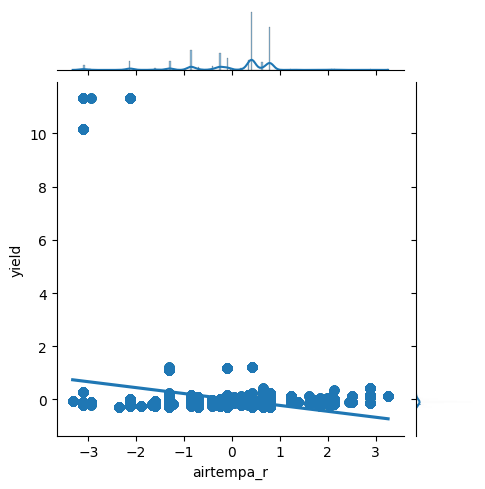

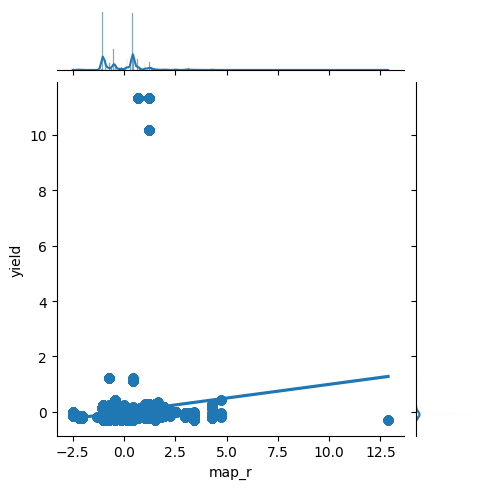

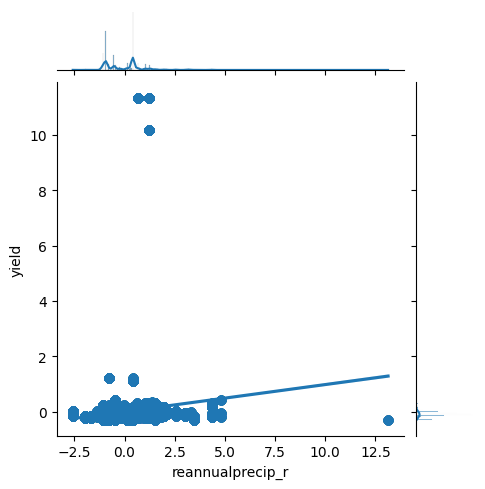

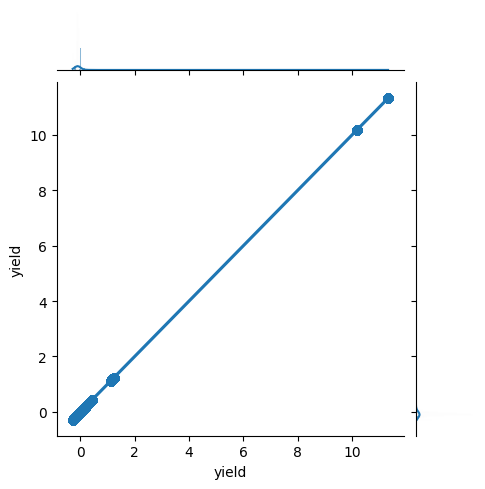

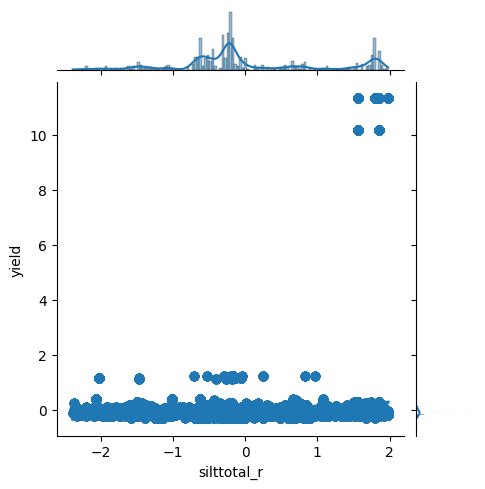

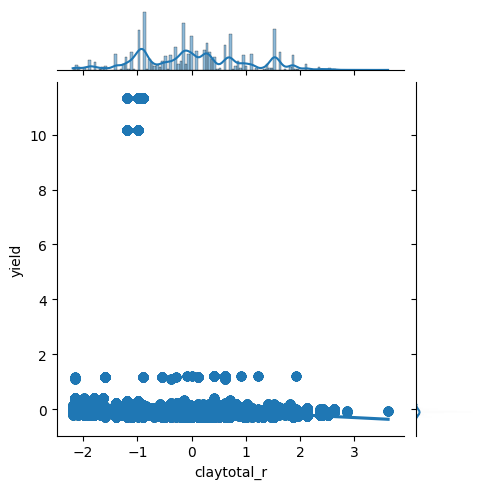

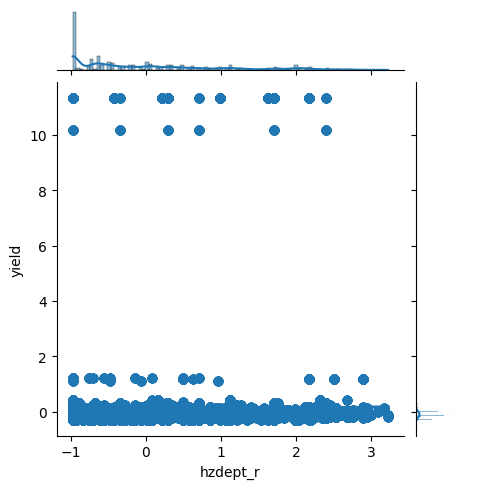

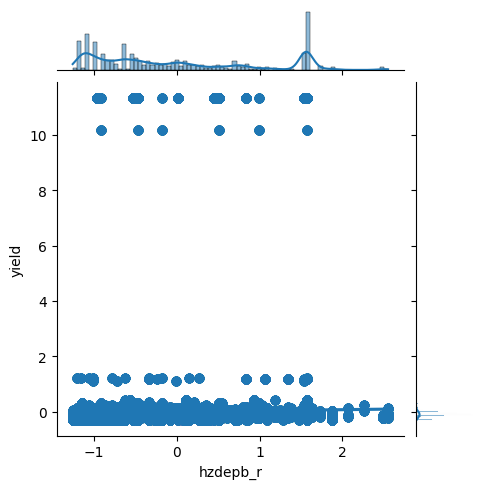

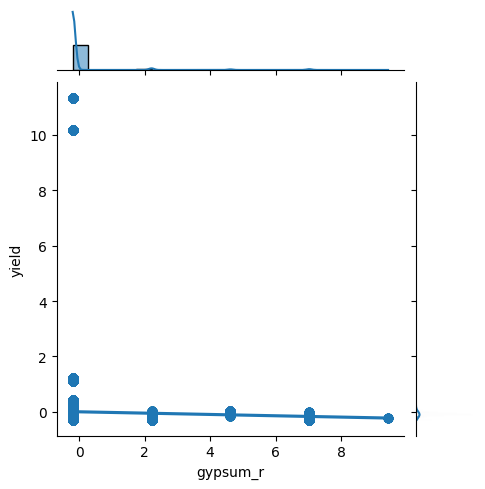

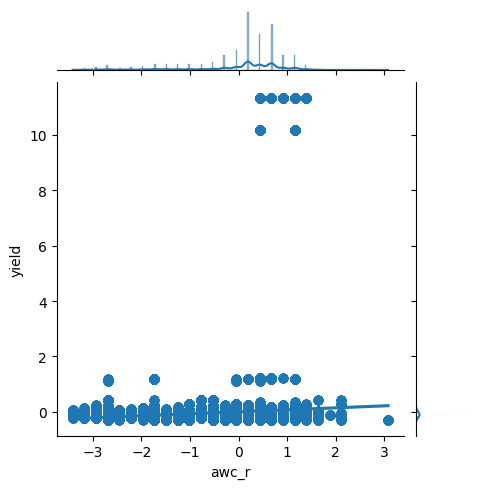

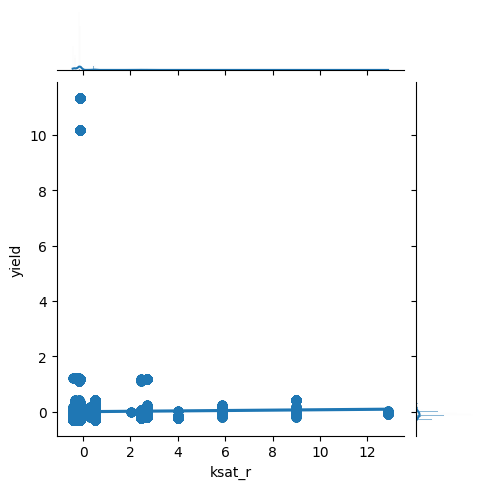

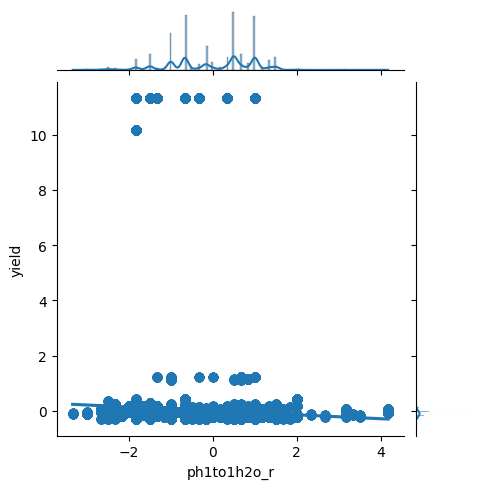

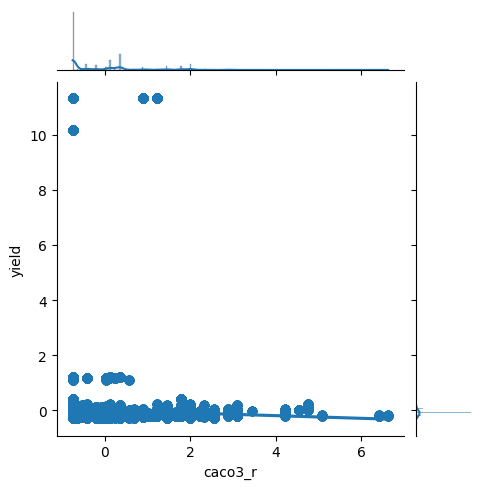

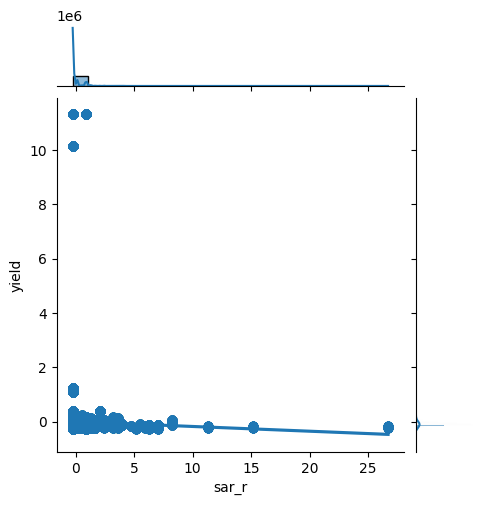

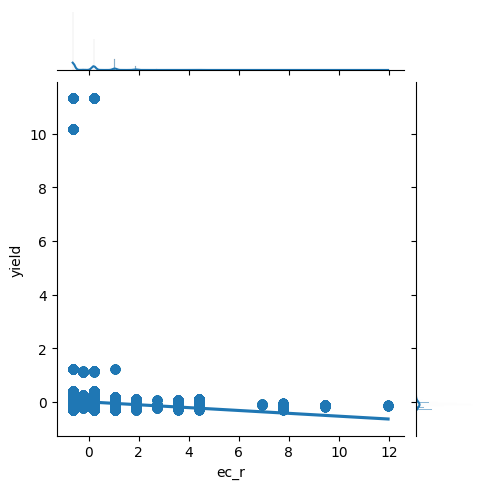

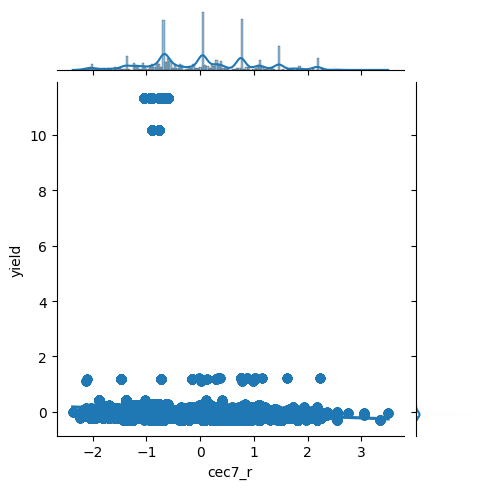

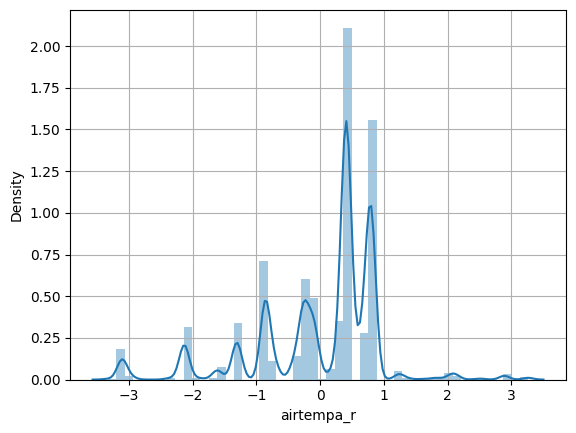

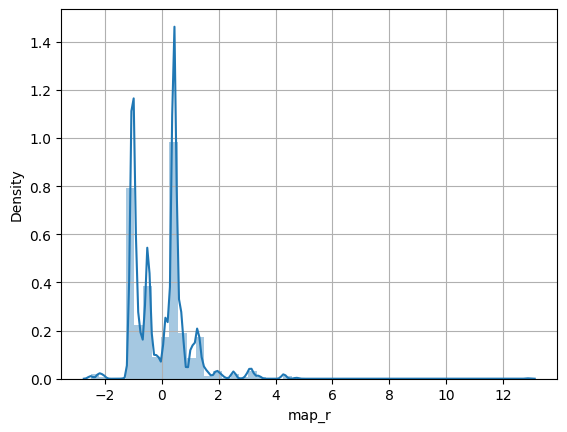

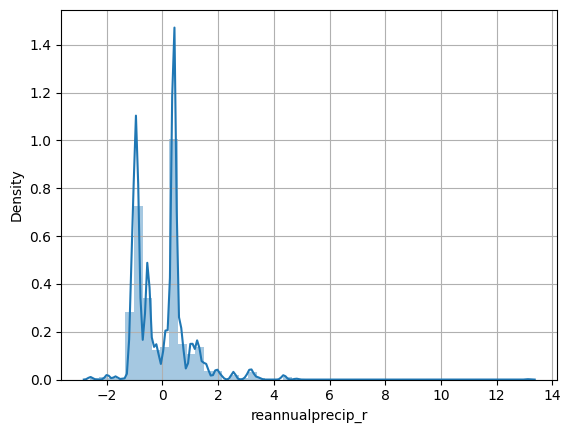

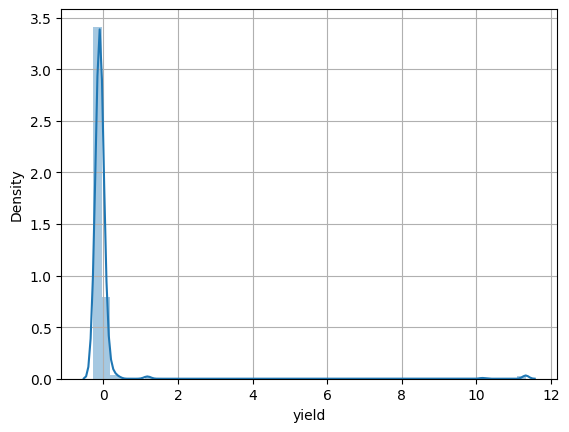

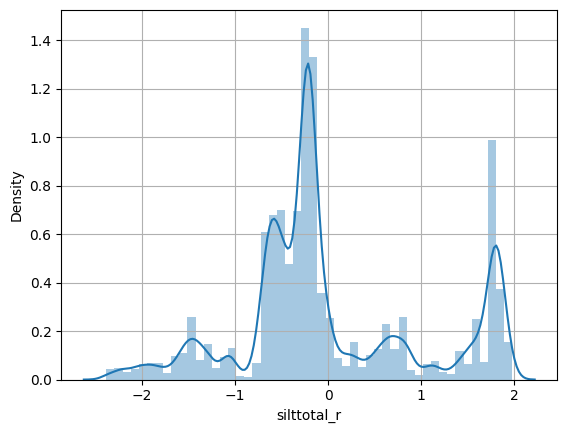

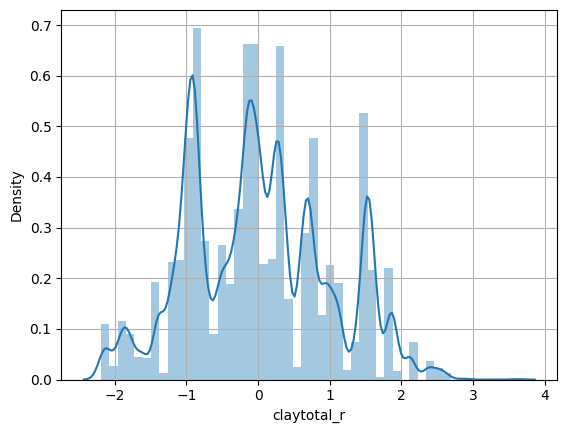

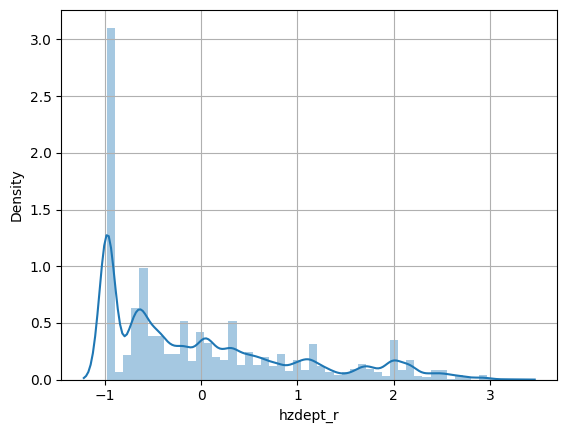

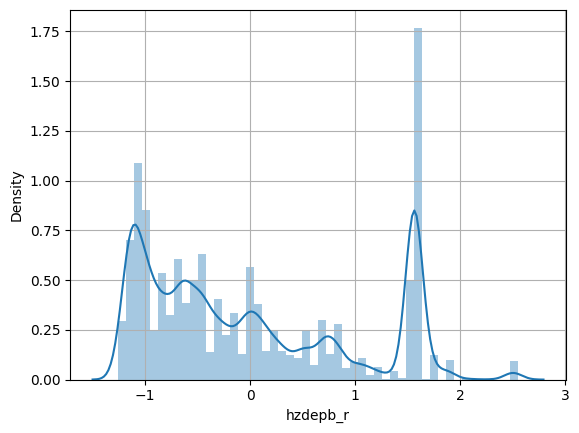

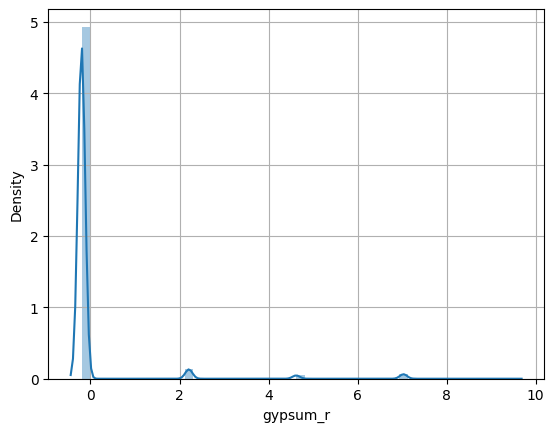

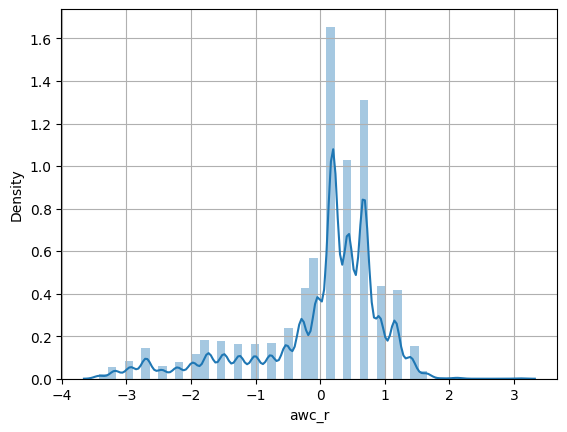

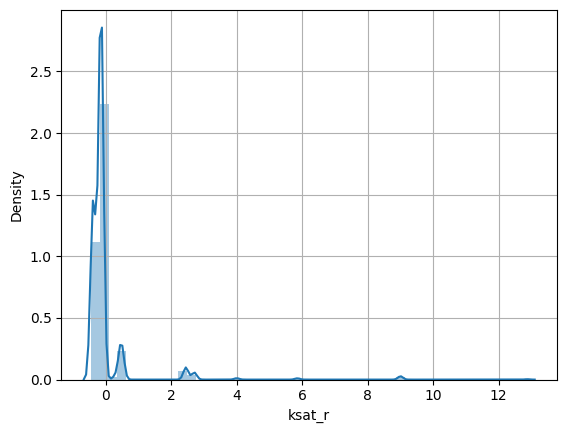

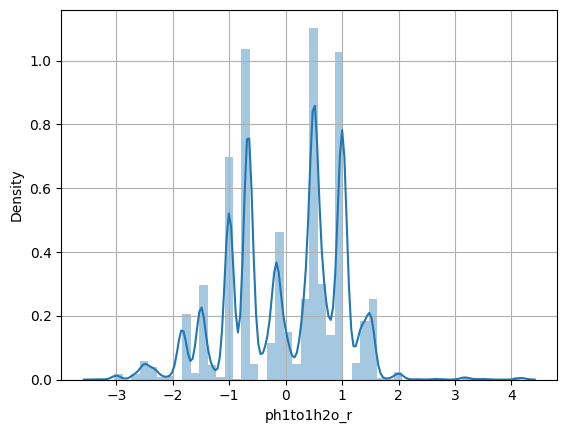

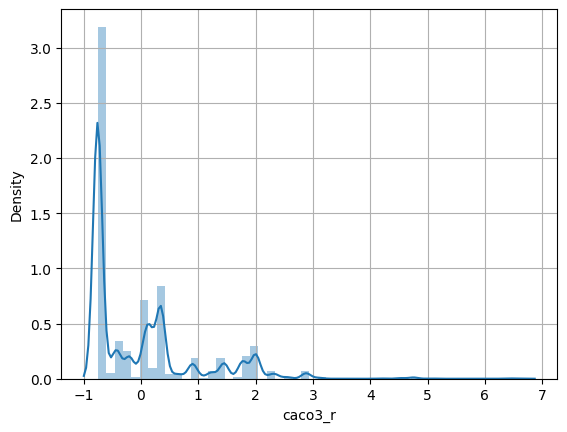

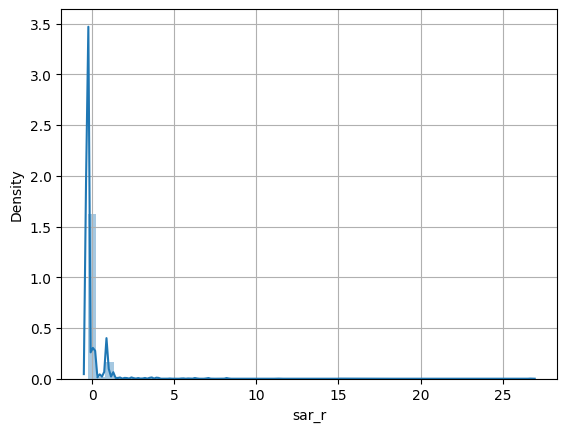

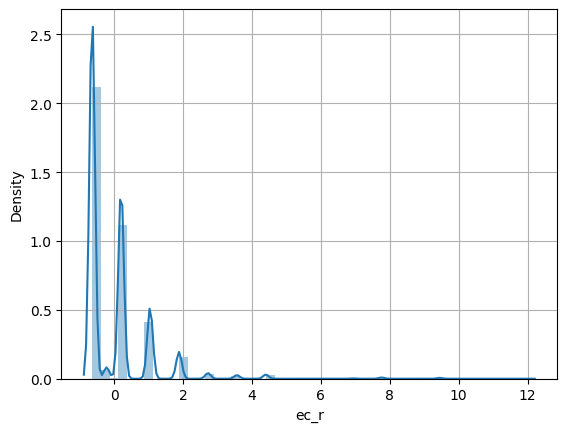

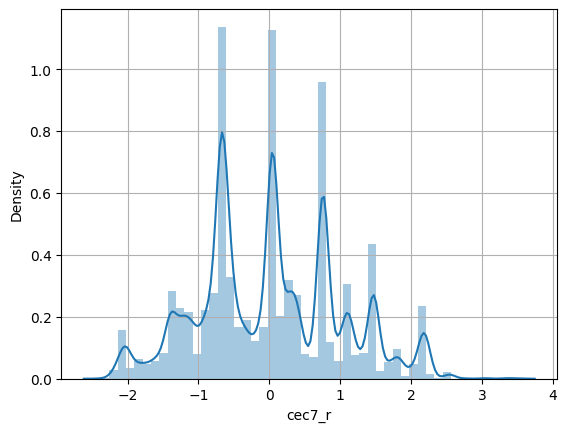

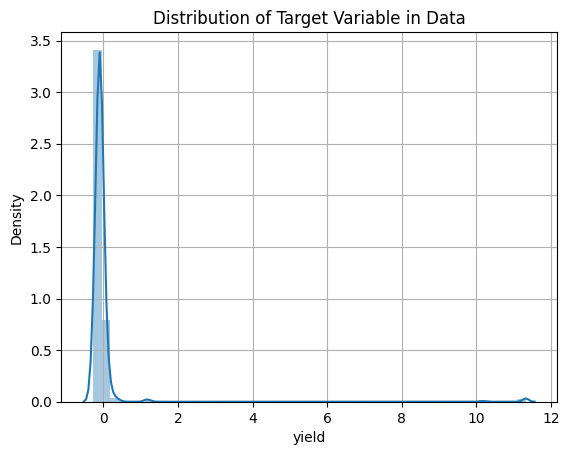

max: 11.321729641390355
min: -0.283372873914229


In [54]:
#PART 3 - DATA VISUALIZATIONS

#joint plot for numeric features
for c in num_cols:
    sns.jointplot(x=c, y="yield", data=final_data, kind = 'reg', height = 5)
plt.show()

#plotted distributions for numeric features
for c in num_cols:
    sns.distplot(final_data[c])
    plt.grid()
    plt.show()

#distribution of target variable
sns.distplot(final_data['yield'])
plt.grid()
plt.title('Distribution of Target Variable in Data')
plt.show()
print('max:', np.max(final_data['yield']))
print('min:', np.min(final_data['yield']))

In [40]:
#Part 4 - Train/Test Split
y = final_data['yield'] 
X = final_data.drop(columns=['yield'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1) #66% for training, 33% for testing

print("Training Set Dimensions:", X_train.shape)
print("Validation Set Dimensions:", X_test.shape)

Training Set Dimensions: (195532, 43)
Validation Set Dimensions: (96308, 43)


In [44]:
#MODEL 1 - Linear Regression w/ Ridge + Lasso Regularization & MAE/MSE Loss Function
#MODEL 1 - TRAINING
reg=LinearRegression()
reg.fit(X_train, y_train)

actual_yield = y_train
predicted_yield = reg.predict(X_train)

mae_train = mean_absolute_error(actual_yield,predicted_yield)
mse_train = mean_squared_error(actual_yield,predicted_yield)**0.5

print(mae_train)
print(mse_train)

0.05048359747841349
0.08306255145093458


In [46]:
#MODEL 1 - get predictions for test data based on the linear regression model trained on training data
predicted_yield_test = reg.predict(X_test)
actual_yield_test = y_test

mae_test = mean_absolute_error(actual_yield_test,predicted_yield_test)
mse_test = mean_squared_error(actual_yield_test,predicted_yield_test)**0.5

print(mae_test)
print(mse_test)

0.0503939338652471
0.08367577759536717


0.050418770959099024 0.08366634456620152


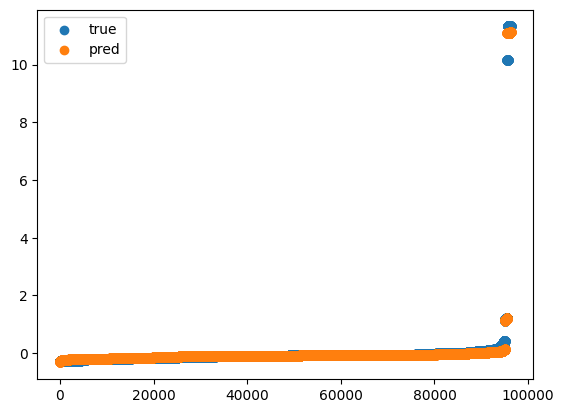

In [47]:
#MODEL 1 - Add Ridge Regularization
ridge = Ridge(alpha=1)
ridge.fit(X_train,y_train)
y_pred = ridge.predict(X_test)
print(mean_absolute_error(y_test,y_pred), mean_squared_error(y_test,y_pred)**0.5)

plt.scatter(np.arange(len(np.sort(y_test))),np.sort(y_test), label='true')
plt.scatter(np.arange(len(np.sort(y_pred))),np.sort(y_pred), label = 'pred')
plt.legend()

0.20720568432796477 1.007174688788966


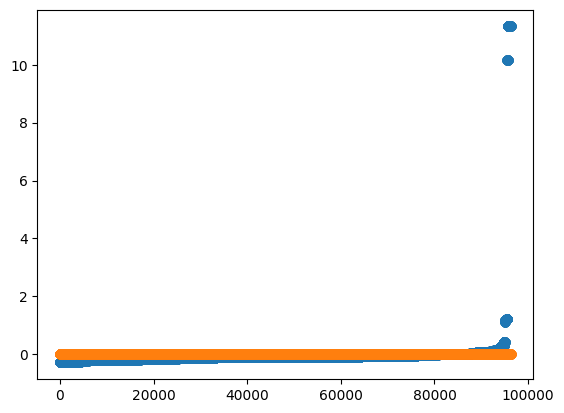

In [48]:
#MODEL 1 - Add Lasso Regularization
lasso = Lasso(alpha=1)
lasso.fit(X_train,y_train)
y_pred = lasso.predict(X_test)
print(mean_absolute_error(y_test,y_pred), mean_squared_error(y_test,y_pred)**0.5)

plt.scatter(np.arange(len(np.sort(y_test))),np.sort(y_test))
plt.scatter(np.arange(len(np.sort(y_pred))),np.sort(y_pred))

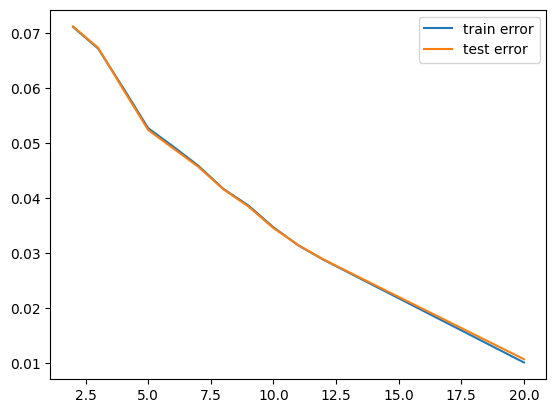

In [49]:
#Model 2 - Decision Tree Regression Model w/ MAE 
decisiontree = DecisionTreeRegressor(max_depth = 10, min_samples_split = 5)
decisiontree.fit(X_train, y_train)

#evaluating train error
mean_absolute_error(y_train,decisiontree.predict(X_train))

max_depth_list = [2,3,4,5,6,7,8,9,10,11,12,20]
train_error = []
test_error =[]

for md in max_depth_list:

    decisiontree = DecisionTreeRegressor(max_depth = md, min_samples_split = 2)
    decisiontree.fit(X_train, y_train)
    train_error.append(mean_absolute_error(y_train,decisiontree.predict(X_train)))
    test_error.append(mean_absolute_error(y_test,decisiontree.predict(X_test)))

plt.plot(max_depth_list,train_error,label = 'train error')
plt.plot(max_depth_list,test_error,label = 'test error')
plt.legend()


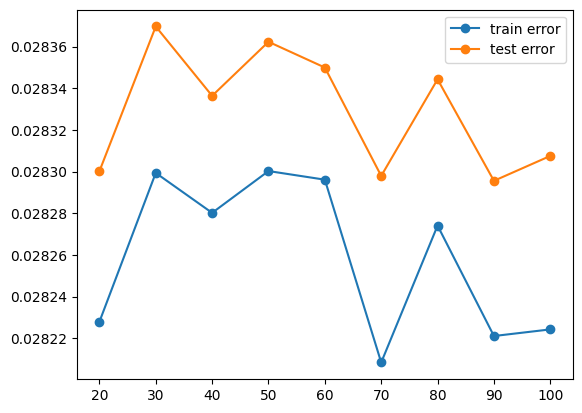

In [50]:
#Model 2 - Random Forest Regressor
randomf = RandomForestRegressor()
randomf.fit(X_train, y_train)
mean_absolute_error(y_train,randomf.predict(X_train))

max_depth_list = [10,11,12,13,14,15,16,17,18,19,20]
train_error = []
test_error =[]
N_estimator=[20,30,40,50,60,70,80,90,100]
for n in N_estimator:

    decisiontree = RandomForestRegressor(n_estimators=n, max_depth = 12, min_samples_split = 2)
    decisiontree.fit(X_train, y_train)
    train_error.append(mean_absolute_error(y_train,decisiontree.predict(X_train)))
    test_error.append(mean_absolute_error(y_test,decisiontree.predict(X_test)))

plt.plot(N_estimator,train_error,marker='o',label = 'train error')
plt.plot(N_estimator,test_error,marker='o',label = 'test error')
plt.legend()


In [56]:
#MODEL 2 - Final Comparison using optimal parameters
decisiontree = DecisionTreeRegressor(max_depth = 20, min_samples_split = 5)
decisiontree.fit(X_train, y_train)

print("Decision Tree")
print(mean_squared_error(y_train,decisiontree.predict(X_train))**0.5)
print(mean_squared_error(y_test,decisiontree.predict(X_test))**0.5)
print(mean_absolute_error(y_train,decisiontree.predict(X_train)))
print(mean_absolute_error(y_test,decisiontree.predict(X_test)))

rf = RandomForestRegressor(n_estimators=70, max_depth = 12, min_samples_split = 2)
rf.fit(X_train, y_train)

print("\n")
print("Random Forest")
print(mean_squared_error(y_train,rf.predict(X_train))*0.5)
print(mean_squared_error(y_test,rf.predict(X_test))*0.5)
print(mean_absolute_error(y_train,rf.predict(X_train)))
print(mean_absolute_error(y_test,rf.predict(X_test)))

Decision Tree
0.0006390766363030375
0.0010197583236202703
0.010162637142163405
0.010716158474798612


Random Forest
0.0013895118981985535
0.0015813613972515271
0.02824180640900949
0.02829909357377263


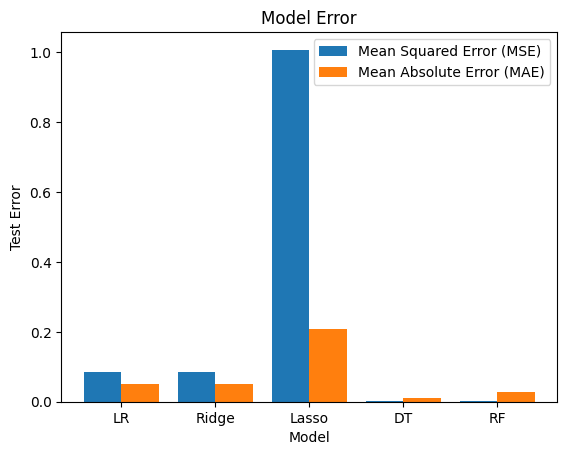

In [10]:


models = ["LR","Ridge", "Lasso", "DT","RF"]



mse_test = [0.08367577759536717,0.08366634456620152,1.007174688788966,0.0010197583236202703,0.0015813613972515271]
mae_test = [0.0503939338652471,0.050418770959099024,0.20720568432796477,0.010716158474798612,0.02829909357377263]


X_axis = np.arange(len(models)) 
  
plt.bar(X_axis - 0.2, mse_test, 0.4, label = 'Mean Squared Error (MSE)') 
plt.bar(X_axis + 0.2, mae_test, 0.4, label = 'Mean Absolute Error (MAE)') 
  
plt.xticks(X_axis, models) 
plt.xlabel("Model") 
plt.ylabel("Test Error") 
plt.title("Model Error") 
plt.legend() 

plt.show() 



Overlap between train and test error, implying that the model is not overfitting and is well generalized